In [1]:
import sys
!{sys.executable} -m pip install numpy pandas 


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\hp\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv(r'C:\Users\hp\Downloads\train(1)(train(1)).csv')

In [4]:
import seaborn as sns 
import os
from PIL import Image
import random

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [6]:
df["image_path"] = df.index.map(lambda idx: f"images/satellite/{idx}.png")
df_img = df[df["image_path"].apply(os.path.exists)].copy()
df_img['price'] = df['price'][:df_img['image_path'].size]

In [7]:
df_img['price'].size

6024

In [8]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from tqdm import tqdm


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [10]:
resnet_feat = models.resnet18(pretrained=True)
resnet_feat = nn.Sequential(*list(resnet_feat.children())[:-1])
resnet_feat = resnet_feat.to(device)
resnet_feat.eval()


C:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [11]:
resnet_cam = models.resnet18(pretrained=True)
resnet_cam = resnet_cam.to(device)
resnet_cam.eval()

target_layer = resnet_cam.layer4



In [12]:
import cv2
import numpy as np

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor):
        self.model.zero_grad()

        output = self.model(input_tensor)
        output.mean().backward()

        gradients = self.gradients[0].cpu().data.numpy()
        activations = self.activations[0].cpu().data.numpy()

        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * activations[i]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224))
        cam = cam / (cam.max() + 1e-8)

        return cam


In [13]:
from PIL import Image
import matplotlib.pyplot as plt

def show_gradcam(image_path):
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    gradcam = GradCAM(resnet_cam, target_layer)
    cam = gradcam.generate(img_tensor)

    img_np = np.array(img.resize((224, 224)))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(5,5))
    plt.imshow(overlay)
    plt.axis("off")
    plt.title("Grad-CAM: Influential Regions")
    plt.show()


In [14]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [15]:
def extract_embedding(image_path):
    img = Image.open(image_path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        feat = resnet_feat(img)
    
    return feat.squeeze().cpu().numpy()


In [16]:
embeddings = []

for path in tqdm(df_img["image_path"]):
    emb = extract_embedding(path)
    embeddings.append(emb)

embeddings = np.vstack(embeddings)


100%|██████████████████████████████████████████████████████████████████████████████| 6024/6024 [12:46<00:00,  7.86it/s]


In [17]:
img_features = pd.DataFrame(
    embeddings,
    index=df_img.index,
    columns=[f"img_feat_{i}" for i in range(512)]
)

df_img = pd.concat([df_img, img_features], axis=1)


In [18]:
img_features.var().describe()


count    512.000000
mean       0.285196
std        0.274150
min        0.010543
25%        0.101177
50%        0.203336
75%        0.369312
max        2.377091
dtype: float64

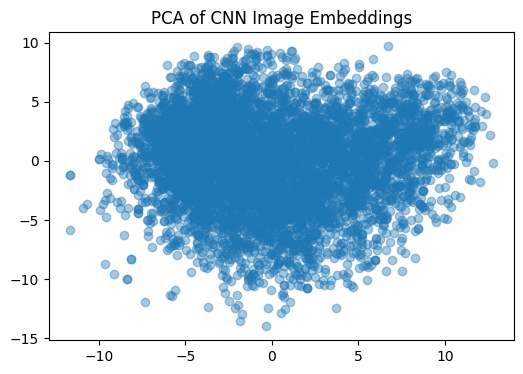

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_feats = pca.fit_transform(img_features)

plt.figure(figsize=(6,4))
plt.scatter(pca_feats[:,0], pca_feats[:,1], alpha=0.4)
plt.title("PCA of CNN Image Embeddings")
plt.show()


In [20]:
df["basement_ratio"] = df["sqft_basement"] / (df["sqft_living"] + 1)
df.drop(columns=["sqft_above", "sqft_basement"], inplace=True)
df["living_vs_neighbors"] = df["sqft_living"] / (df["sqft_living15"] + 1)
df["lot_vs_neighbors"] = df["sqft_lot"] / (df["sqft_lot15"] + 1)
df["is_renovated"] = (df["yr_renovated"] > 0).astype(int)
df.drop(columns=["yr_renovated"], inplace=True)
df["log_price"] = np.log1p(df["price"])
df["sqft_living"]=np.log1p(df['sqft_living'])
df["has_view"] = (df["view"] > 0).astype(int)

In [21]:
FEATURES = [
    "sqft_living",
    "sqft_lot",
    "bedrooms", "bathrooms", "floors",
    "condition", "grade",
    "waterfront", "has_view",
    "living_vs_neighbors", "lot_vs_neighbors",
    "basement_ratio",
    "is_renovated"
]
df_img[FEATURES] = df[FEATURES][:df_img['price'].size]

In [22]:
X_tab = df_img[FEATURES].values
X_img = img_features.loc[df_img.index].values

y = np.log1p(df_img["price"].values)

In [23]:
X_tab_train, X_tab_test, X_img_train, X_img_test, y_train, y_test = train_test_split(
    X_tab, X_img, y, test_size=0.2, random_state=45
)

In [24]:
X_train_fused = np.hstack([X_tab_train, X_img_train])
X_test_fused = np.hstack([X_tab_test, X_img_test])

In [25]:
from sklearn.metrics import mean_squared_error, r2_score

In [26]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor(
    n_estimators=500,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

In [27]:
xgb_model.fit(
    X_tab_train, y_train,
    verbose=False
)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [28]:
y_pred_xgb = xgb_model.predict(X_tab_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

rmse_xgb, r2_xgb

(np.float64(0.31333317940895367), 0.6448597867501065)

In [29]:
xgb_model.fit(
    X_train_fused, y_train,
    verbose=False
)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [30]:
y_pred_xgb = xgb_model.predict(X_test_fused)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

rmse_xgb, r2_xgb

(np.float64(0.28735353940002384), 0.7013103446974027)

In [31]:
from lightgbm import LGBMRegressor
lgb_model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

In [32]:
lgb_model.fit(X_train_fused, y_train)
y_pred_lgb = lgb_model.predict(X_test_fused)

rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
r2_lgb = r2_score(y_test, y_pred_lgb)

rmse_lgb, r2_lgb

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 131896
[LightGBM] [Info] Number of data points in the train set: 4819, number of used features: 525
[LightGBM] [Info] Start training from score 13.045445


C:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


(np.float64(0.28548763896446283), 0.7051767713473207)

In [33]:
lgb_model.fit(X_tab_train, y_train)
y_pred_lgb = lgb_model.predict(X_tab_test)

rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
r2_lgb = r2_score(y_test, y_pred_lgb)

rmse_xgb, r2_xgb

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 4819, number of used features: 13
[LightGBM] [Info] Start training from score 13.045445


C:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


(np.float64(0.28735353940002384), 0.7013103446974027)

In [34]:
convnext = models.convnext_tiny(weights="IMAGENET1K_V1")
convnext.eval()
convnext = convnext.to(device)

In [35]:
convnext.classifier = nn.Identity()

In [36]:
def extract_convnext_embedding(image_path, model):
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        features = model(img_tensor)

    return features.squeeze().cpu().numpy()

In [37]:
embeddings = []
indices = []

for idx in df_img.index:
    img_path = f"images/satellite/{idx}.png"
    if not os.path.exists(img_path):
        continue

    emb = extract_convnext_embedding(img_path, convnext)
    embeddings.append(emb)
    indices.append(idx)

img_features = pd.DataFrame(
    embeddings,
    index=indices
)


In [38]:
pca = PCA(n_components=64)
img_features_pca = pca.fit_transform(img_features)

In [39]:
X_img = img_features_pca

In [40]:
X_tab_train, X_tab_test, X_img_train, X_img_test, y_train, y_test = train_test_split(
    X_tab, X_img, y, test_size=0.2, random_state=45
)

X_train_fused = np.hstack([X_tab_train, X_img_train])
X_test_fused = np.hstack([X_tab_test, X_img_test])

In [41]:
lgb_model.fit(X_train_fused, y_train)
y_pred_lgb = lgb_model.predict(X_test_fused)

rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
r2_lgb = r2_score(y_test, y_pred_lgb)

rmse_lgb, r2_lgb

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17656
[LightGBM] [Info] Number of data points in the train set: 4819, number of used features: 77
[LightGBM] [Info] Start training from score 13.045445


C:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


(np.float64(0.2757868910593139), 0.7248722996057555)

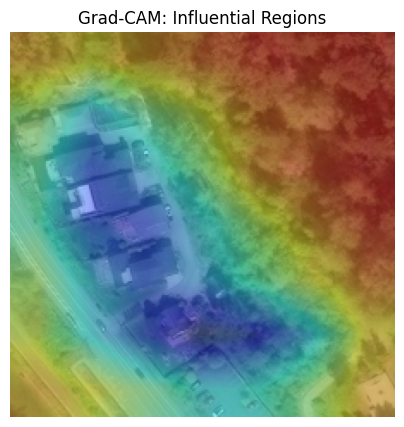

In [74]:
show_gradcam(df_img["image_path"].iloc[5700]) 
#this was made when the complete training was done 

In [43]:
df_test = pd.read_csv(r"C:\Users\hp\Downloads\test2(test(1)).csv")

In [44]:
df_test["basement_ratio"] = df_test["sqft_basement"] / (df_test["sqft_living"] + 1)
df_test.drop(columns=["sqft_above", "sqft_basement"], inplace=True)
df_test["living_vs_neighbors"] = df_test["sqft_living"] / (df_test["sqft_living15"] + 1)
df_test["lot_vs_neighbors"] = df_test["sqft_lot"] / (df_test["sqft_lot15"] + 1)
df_test["is_renovated"] = (df_test["yr_renovated"] > 0).astype(int)
df_test.drop(columns=["yr_renovated"], inplace=True)
df_test["sqft_living"]=np.log1p(df_test['sqft_living'])
df_test["has_view"] = (df_test["view"] > 0).astype(int)

In [54]:
FEATURES = [
    "sqft_living",
    "sqft_lot",
    "bedrooms", "bathrooms", "floors",
    "condition", "grade",
    "waterfront", "has_view",
    "living_vs_neighbors", "lot_vs_neighbors",
    "basement_ratio",
    "is_renovated"
]
X_tab_test = df_test[FEATURES]

In [46]:
IMAGE_DIR = "images/test"
os.makedirs(IMAGE_DIR, exist_ok=True)

print("Image directory ready:", IMAGE_DIR)

Image directory ready: images/test


In [47]:
from data_fetch import fetch_satellite_image

In [48]:
import time

for idx, row in df_test.iterrows():
    path = f"images/test/{idx}.png"
    if not os.path.exists(path):
        fetch_satellite_image(row["lat"], row["long"], path)
        time.sleep(0.1)

In [50]:
df_test["image_path"] = df_test.index.map(lambda idx: f"images/test/{idx}.png")

In [51]:
embeddings = []
indices = []

for idx in df_test.index:
    img_path = f"images/test/{idx}.png"
    if not os.path.exists(img_path):
        continue

    emb = extract_convnext_embedding(img_path, convnext)
    embeddings.append(emb)
    indices.append(idx)

img_features_test = pd.DataFrame(
    embeddings,
    index=indices
)

In [56]:
img_features_test_pca = pca.fit_transform(img_features_test)

In [58]:
X_img_test = img_features_test_pca
X_test_fused = np.hstack([X_tab_test, X_img_test])
y_pred_lgb = lgb_model.predict(X_test_fused)

C:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [59]:
df = pd.DataFrame({
    "prediction": y_pred_lgb
})

df.to_csv("lgb_predictions.csv", index=False)
#exponent taken in the file 